In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
import requests
import plotly as ply
from sklearn.impute import KNNImputer



In [270]:

# the relative path of the stroke csv dataset is saved into the variable data for ease of use
data = '../data/processed/stroke_copy_processed.csv'

# The data is read and saved in a variable (stroke)
stroke_copy_processed = pd.read_csv(data)

stroke_copy_processed = pd.DataFrame(stroke_copy_processed)

In [271]:
# Removing all stroke positive patients under the age of 18 years
stroke_adults = stroke_copy_processed[stroke_copy_processed['age'] >= 18]

# This data set is only comprised of patients who have suffered a stroke and are over the age of 18+ (Adult)
stroke_adults = pd.DataFrame(stroke_adults)


stroke_adults

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_category,bmi_category,glucose_category
0,9046,Male,67.0,0,1,Yes,Private,Urban,229,37,formerly smoked,1,Senior,Obesity,Diabetic
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202,34,never smoked,1,Adult,Obesity,Diabetic
2,31112,Male,80.0,0,1,Yes,Private,Rural,106,32,never smoked,1,Senior,Obesity,Healthy
3,60182,Female,49.0,0,0,Yes,Private,Urban,171,34,smokes,1,Adult,Obesity,Pre-Diabetic
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174,24,never smoked,1,Senior,Healthy Weight,Pre-Diabetic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,84,27,never smoked,0,Senior,Overweight,Healthy
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125,40,never smoked,0,Senior,Obesity,Healthy
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,83,31,never smoked,0,Adult,Obesity,Healthy
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166,26,formerly smoked,0,Adult,Overweight,Pre-Diabetic


## Plots
- using stroke_adults df we proced with the visual exploration of our dataset

## Number of Patients vs. Stroke Status

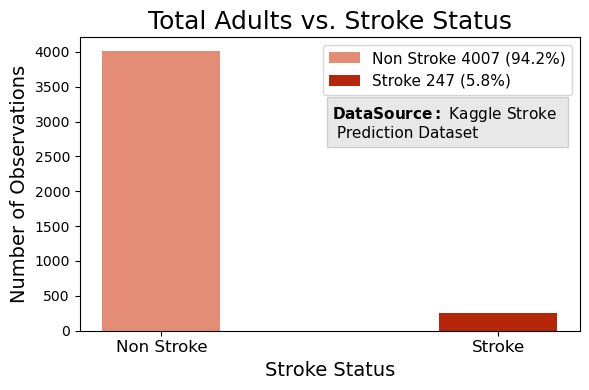

In [272]:
# Graphic 1: Number of Patients vs. Stroke Status

# Count patients in each stroke category (0 = No, 1 = Yes)
sum_stroke = stroke_adults['stroke'].value_counts().sort_index()

# Calculate percentages
total = sum_stroke.sum()
percentages = (sum_stroke / total * 100).round(1)

# Create figure
fig, ax = plt.subplots(figsize=(6,4))

# Plot bars
bars = ax.bar(sum_stroke.index, sum_stroke.values,
              color=["#e38d77", "#b5270b"],
              width=0.35)

# Build legend labels with counts + percentages
legend_labels = [
    f'Non Stroke {sum_stroke[0]} ({percentages[0]}%)',
    f'Stroke {sum_stroke[1]} ({percentages[1]}%)'
]

# Attach labels to each bar
for bar, label in zip(bars, legend_labels):
    bar.set_label(label)

# Add legend
ax.legend(loc='upper right', fontsize=11)

# Titles and labels
ax.set_title('Total Adults vs. Stroke Status', fontsize=18)
ax.set_xlabel('Stroke Status', fontsize=14)
ax.set_ylabel('Number of Observations', fontsize=14)
ax.set_xticks([0,1])
ax.set_xticklabels(['Non Stroke','Stroke'], fontsize=12)

# Create text box below plot to indicate data source for data transparency purposes, and to outline bin parameters to provide audience with context
plt.text(
    0.505, 0.77,  # Text positioning from axes
     '$\mathbf{Data Source:}$ Kaggle Stroke  \n Prediction Dataset', # Text - Data Source
    transform=plt.gca().transAxes,  # place relative to entire figure
    fontsize=11,
    color='black',
    ha='left',  # Horizontal text alignment inside box
    va='top',   # Vertical text alignment inside box
    bbox=dict(
        facecolor='lightgrey',   # Light red background,
        alpha=0.5,
        edgecolor='darkgrey',    # Border color
    )
)
plt.tight_layout()
plt.savefig('../images/stroke_comparative_visualizations/comparative_total.png', format="png", dpi=300,)
plt.show()



# Tornado chart with matplotlib Stroke vs. Comorbidities: Hypertension and Heard Disease

In [273]:

# df copy to graph comorbilities in patients with and without stroke: HTA and HD
comorb_df = stroke_adults[['hypertension','heart_disease','stroke']].copy()
comorb_df.head()

## Means HTA and HD

# Step 1: Counts
stroke_yes_total = (comorb_df['stroke'] == 1).sum()
stroke_no_total = (comorb_df['stroke'] == 0).sum()

# Within stroke=1
hta_stroke = ((comorb_df['stroke'] == 1) & (comorb_df['hypertension'] == 1)).sum()
hd_stroke  = ((comorb_df['stroke'] == 1) & (comorb_df['heart_disease'] == 1)).sum()

# Within stroke=0
hta_no_stroke = ((comorb_df['stroke'] == 0) & (comorb_df['hypertension'] == 1)).sum()
hd_no_stroke  = ((comorb_df['stroke'] == 0) & (comorb_df['heart_disease'] == 1)).sum()


# Calculate the mean: 
# Within stroke=1
hta_stroke_mean = (hta_stroke / stroke_yes_total)*100
hd_stroke_mean  = (hd_stroke / stroke_yes_total)*100

# Within stroke=0
hta_no_stroke_mean = (hta_no_stroke / stroke_no_total)*100
hd_no_stroke_mean  = (hd_no_stroke / stroke_no_total)*100


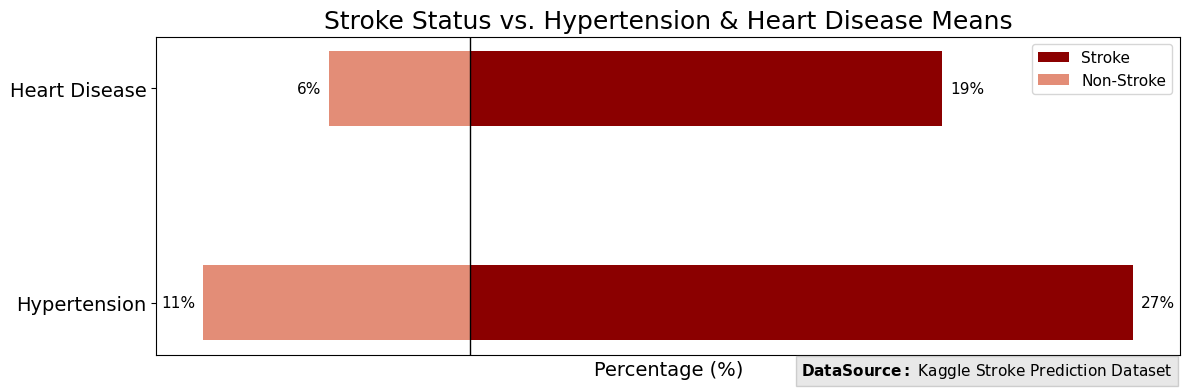

In [274]:
# Labels
labels = ["Hypertension", "Heart Disease"]

# Values (percentages)
stroke_means = np.array([hta_stroke_mean, hd_stroke_mean])           # Stroke group
non_stroke_means = np.array([hta_no_stroke_mean, hd_no_stroke_mean]) # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 4))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, but values shifted to negative for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels in bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text((width + 0.3),                      # place label slightly to the right of the bar
            bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.3,                      # place label slightly to the left of the bar
            bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status vs. Hypertension & Heart Disease Means", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()

# Create text box below plot to indicate data source for data transparency purposes, and to outline bin parameters to provide audience with context
plt.text(
    0.63, -0.02,  # Text positioning from axes
     '$\mathbf{Data Source:}$ Kaggle Stroke Prediction Dataset', # Text - Data Source
    transform=plt.gca().transAxes,  # place relative to entire figure
    fontsize=11,
    color='black',
    ha='left',  # Horizontal text alignment inside box
    va='top',   # Vertical text alignment inside box
    bbox=dict(
        facecolor='lightgrey',   # Light red background,
        alpha=0.5,
        edgecolor='darkgrey',    # Border color
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_comorb.png', format="png", dpi=300)
plt.show()

# Tornado chart with matplotlib Stroke vs. Risk Factors:  BMI and Smoke Status and Glucosa Category

In [275]:
# df copy to graph risk factors processed in patients with and without stroke: smoke, BMI and Glucose

risk_f_df = stroke_adults[['avg_glucose_level'	, 'bmi', 'bmi_category', 'glucose_category', 'age_category',  'smoking_status', 'stroke']].copy()
risk_f_df.head()

,avg_glucose_level,bmi,bmi_category,glucose_category,age_category,smoking_status,stroke
0,229,37,Obesity,Diabetic,Senior,formerly smoked,1
1,202,34,Obesity,Diabetic,Adult,never smoked,1
2,106,32,Obesity,Healthy,Senior,never smoked,1
3,171,34,Obesity,Pre-Diabetic,Adult,smokes,1
4,174,24,Healthy Weight,Pre-Diabetic,Senior,never smoked,1


### BMI Categories

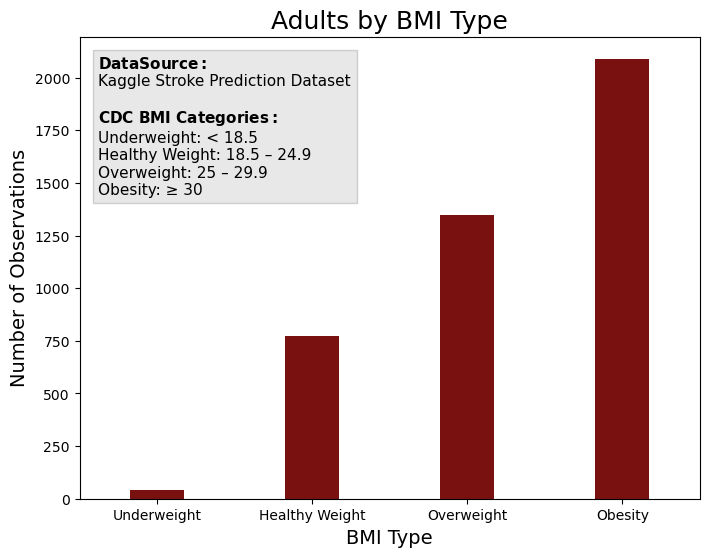

In [276]:
#Order of labels: 
bmi_order = ['Underweight', 'Healthy Weight', 'Overweight', 'Obesity']

# Set figure size
plt.figure(figsize=(8,6))

# Bar Plot for Count of patients by BMI (categories)
sns.countplot(data=risk_f_df, x='bmi_category',order=bmi_order, color='darkred', width=0.35)
plt.title('Adults by BMI Type', fontsize=18)
plt.xlabel('BMI Type', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)

# Text box with data source,  BMI categories
plt.text(
    0.03, 0.96,  # Position relative to axes
    (
        '$\mathbf{Data Source:}$\n'
        'Kaggle Stroke Prediction Dataset\n\n'
        '$\mathbf{CDC\ BMI\ Categories:}$\n'
        'Underweight: < 18.5\n'
        'Healthy Weight: 18.5 – 24.9\n'
        'Overweight: 25 – 29.9\n'
        'Obesity: ≥ 30'
    ),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.savefig('../images/stroke_comparative_visualizations/total_by_bmi_category.png', format="png", dpi=300)
plt.show()

In [277]:
## Means bmi categories stroke and non stroke


# Step 1: Counts Stroke and non stroke
stroke_yes_total = (risk_f_df['stroke'] == 1).sum()
stroke_no_total = (risk_f_df['stroke'] == 0).sum()

# Within stroke=1
ow_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['bmi_category'] == 'Overweight')).sum()
ob_stroke  = ((risk_f_df['stroke'] == 1) & (risk_f_df['bmi_category'] == 'Obesity')).sum()
hw_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['bmi_category'] == 'Healthy Weight')).sum()
uw_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['bmi_category'] == 'Underweight')).sum()

# Within stroke=0
ow_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['bmi_category'] == 'Overweight')).sum()
ob_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['bmi_category'] == 'Obesity')).sum()
hw_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['bmi_category'] == 'Healthy Weight')).sum()
uw_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['bmi_category'] == 'Underweight')).sum()


# Calculate the mean: 
# Within stroke=1
ow_stroke_mean = (ow_stroke / stroke_yes_total)*100
ob_stroke_mean  = (ob_stroke / stroke_yes_total)*100
hw_stroke_mean  = (hw_stroke / stroke_yes_total)*100
uw_stroke_mean  = (uw_stroke / stroke_yes_total)*100

# Within stroke=0
ow_no_stroke_mean = (ow_no_stroke / stroke_no_total)*100
ob_no_stroke_mean  = (ob_no_stroke / stroke_no_total)*100
hw_no_stroke_mean  = (hw_no_stroke / stroke_no_total)*100
uw_no_stroke_mean  = (uw_no_stroke / stroke_no_total)*100

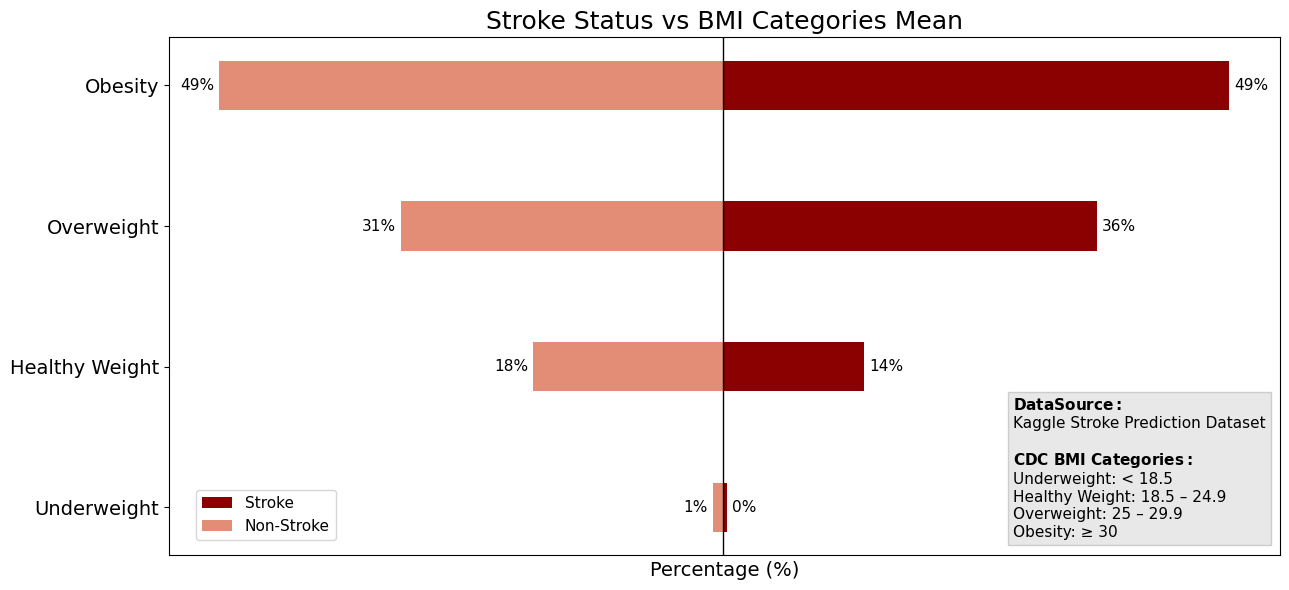

In [278]:
# Labels
labels = ["Underweight", "Healthy Weight", "Overweight", "Obesity"]

# Values (percentages)
stroke_means = np.array([uw_stroke_mean, hw_stroke_mean, ow_stroke_mean, ob_stroke_mean])           # Stroke group
non_stroke_means = np.array([uw_no_stroke_mean, hw_no_stroke_mean, ow_no_stroke_mean, ob_no_stroke_mean]) # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 6))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, values shifted to negative for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels OUTSIDE bars (to the front)
for bar in bars_stroke:
    width = bar.get_width()
    ax.text((width + 0.5),                      # place label slightly to the right of the bar
            bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5,                      # place label slightly to the left of the bar
            bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14 )
ax.set_title("Stroke Status vs BMI Categories Mean", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(
    loc="lower right",
    fontsize=11,
    bbox_to_anchor=(0.15, 0.03),  # move it outside to the right
    borderaxespad=0
)

plt.tight_layout()

# Text box with data source,  BMI categories
plt.text(
    0.76, 0.305,  # Position relative to axes
    (
        '$\mathbf{Data Source:}$\n'
        'Kaggle Stroke Prediction Dataset\n\n'
        '$\mathbf{CDC\ BMI\ Categories:}$\n'
        'Underweight: < 18.5\n'
        'Healthy Weight: 18.5 – 24.9\n'
        'Overweight: 25 – 29.9\n'
        'Obesity: ≥ 30'
    ),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_bmi.png', format="png", dpi=300)
plt.show()

# Smoke Categories

In [279]:
## Means smoking status vrs stroke and non stroke


# Step 1: Counts Stroke and non stroke
stroke_yes_total = (risk_f_df['stroke'] == 1).sum()
stroke_no_total = (risk_f_df['stroke'] == 0).sum()

# Within stroke=1
f_smk_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['smoking_status'] == 'formerly smoked')).sum()
smk_stroke  = ((risk_f_df['stroke'] == 1) & (risk_f_df['smoking_status'] == 'smokes')).sum()
n_smk_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['smoking_status'] == 'never smoked')).sum()
unk_smk_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['smoking_status'] == 'Unknown')).sum()

# Within stroke=0
f_smk_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['smoking_status'] == 'formerly smoked')).sum()
smk_no_stroke   = ((risk_f_df['stroke'] == 0) & (risk_f_df['smoking_status'] == 'smokes')).sum()  
n_smk_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['smoking_status'] == 'never smoked')).sum()
unk_smk_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['smoking_status'] == 'Unknown')).sum()

# Calculate the mean: 
# Within stroke=1
f_smk_stroke_mean = (f_smk_stroke / stroke_yes_total)*100
smk_stroke_mean  = (smk_stroke / stroke_yes_total)*100
n_smk_stroke_mean  = (n_smk_stroke / stroke_yes_total)*100
unk_smk_stroke_mean  = (unk_smk_stroke / stroke_yes_total)*100

# Within stroke=0
f_smk_no_stroke_mean = (f_smk_no_stroke / stroke_no_total)*100
smk_no_stroke_mean  = (smk_no_stroke / stroke_no_total)*100
n_smk_no_stroke_mean  = (n_smk_no_stroke / stroke_no_total)*100
unk_smk_no_stroke_mean  = (unk_smk_no_stroke / stroke_no_total)*100

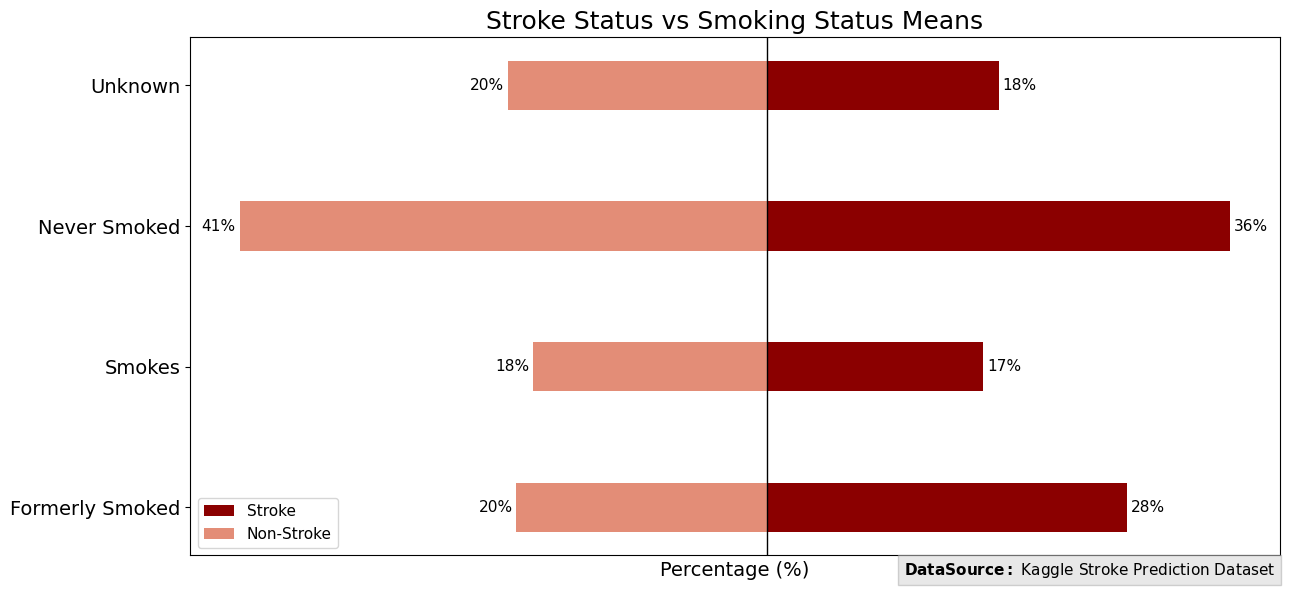

In [280]:
# Labels
labels = ["Formerly Smoked", "Smokes", "Never Smoked", "Unknown"]

# Values (percentages)
stroke_means = np.array([
    f_smk_stroke_mean,
    smk_stroke_mean,
    n_smk_stroke_mean,
    unk_smk_stroke_mean
])  # Stroke group

non_stroke_means = np.array([
    f_smk_no_stroke_mean,
    smk_no_stroke_mean,
    n_smk_no_stroke_mean,
    unk_smk_no_stroke_mean
])  # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 6))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means,
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, values shifted to negative for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means,
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels OUTSIDE bars (to the front)
for bar in bars_stroke:
    width = bar.get_width()
    ax.text((width + 0.3),                      # place label slightly to the right of the bar
            bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.3,                      # place label slightly to the left of the bar
            bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status vs Smoking Status Means", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="lower left", fontsize=11)

plt.tight_layout()
plt.text(
    0.655, -0.01,  # Text positioning from axes
     '$\mathbf{Data Source:}$ Kaggle Stroke Prediction Dataset', # Text - Data Source
    transform=plt.gca().transAxes,  # place relative to entire figure
    fontsize=11,
    color='black',
    ha='left',  # Horizontal text alignment inside box
    va='top',   # Vertical text alignment inside box
    bbox=dict(
        facecolor='lightgrey',   # Light red background,
        alpha=0.5,
        edgecolor='darkgrey',    # Border color
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_smok_stat.png', format="png", dpi=300)
plt.show()

## Glucose Average Category

DM: more than 200mg/dl
Pre Diabetic between 140 and 199 mg/dl
Healthy Glucosa Average: 70 to 139mg/dl
Low: less tan 70

In [281]:
## Means glucosa average per category vrs stroke and non stroke


# Step 1: Counts Stroke and non stroke
stroke_yes_total = (risk_f_df['stroke'] == 1).sum()
stroke_no_total = (risk_f_df['stroke'] == 0).sum()

# Within stroke=1
dm_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['glucose_category'] == 'Diabetic')).sum()
p_dm_stroke  = ((risk_f_df['stroke'] == 1) & (risk_f_df['glucose_category'] == 'Pre-Diabetic')).sum()
h_gav_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['glucose_category'] == 'Healthy')).sum()
l_gav_stroke = ((risk_f_df['stroke'] == 1) & (risk_f_df['glucose_category'] == 'Low')).sum()

# Within stroke=0
dm_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['glucose_category'] == 'Diabetic')).sum()
p_dm_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['glucose_category'] == 'Pre-Diabetic')).sum()
h_gav_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['glucose_category'] == 'Healthy')).sum()
l_gav_no_stroke = ((risk_f_df['stroke'] == 0) & (risk_f_df['glucose_category'] == 'Low')).sum()


# Calculate the mean: 
# Within stroke=1
dm_stroke_mean = (dm_stroke / stroke_yes_total)*100
p_dm_stroke_mean  = (p_dm_stroke / stroke_yes_total)*100
h_gav_stroke_mean  = (h_gav_stroke / stroke_yes_total)*100
l_gav_stroke_mean  = (l_gav_stroke / stroke_yes_total)*100

# Within stroke=0
dm_no_stroke_mean = (dm_no_stroke / stroke_no_total)*100
p_dm_no_stroke_mean  = (p_dm_no_stroke / stroke_no_total)*100
h_gav_no_stroke_mean  = (h_gav_no_stroke / stroke_no_total)*100
l_gav_no_stroke_mean  = (l_gav_no_stroke / stroke_no_total)*100

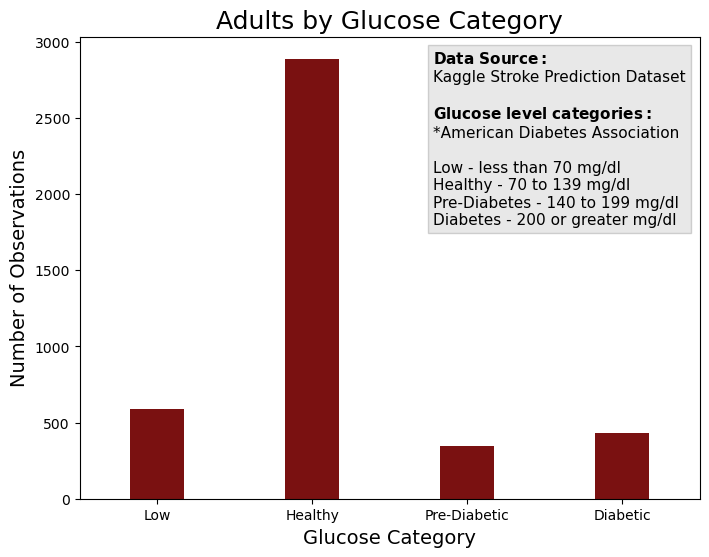

In [282]:
#Order of labels: 
gluc_order = ['Low', 'Healthy', 'Pre-Diabetic', 'Diabetic']

# Set figure size
plt.figure(figsize=(8,6))

# Bar Plot for Count of patients by Glucose Level (categories)

sns.countplot(data=risk_f_df, x='glucose_category', order=gluc_order, color='darkred', width=0.35)
plt.title('Adults by Glucose Category', fontsize=18)
plt.xlabel('Glucose Category', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)
plt.text(
    0.57, 0.97,  # Posición relativa en el gráfico
    (
        r'$\mathbf{Data\ Source:}$'
        '\nKaggle Stroke Prediction Dataset\n'
        '\n'
        r'$\mathbf{Glucose\ level\ categories:}$'
        '\n*American Diabetes Association\n'
        '\nLow - less than 70 mg/dl\n'
        'Healthy - 70 to 139 mg/dl\n'
        'Pre-Diabetes - 140 to 199 mg/dl\n'
        'Diabetes - 200 or greater mg/dl'
    ),
    transform=plt.gca().transAxes,  # relativo al eje
    fontsize=11,
    color='black',
    ha='left',  # alineación horizontal
    va='top',   # alineación vertical
    bbox=dict(
        facecolor='lightgrey',   # fondo gris claro
        alpha=0.5,
        edgecolor='darkgrey',    # borde gris oscuro
    )
)
plt.savefig('../images/stroke_comparative_visualizations/total_by_gluc_category.png', format="png", dpi=300)
plt.show()



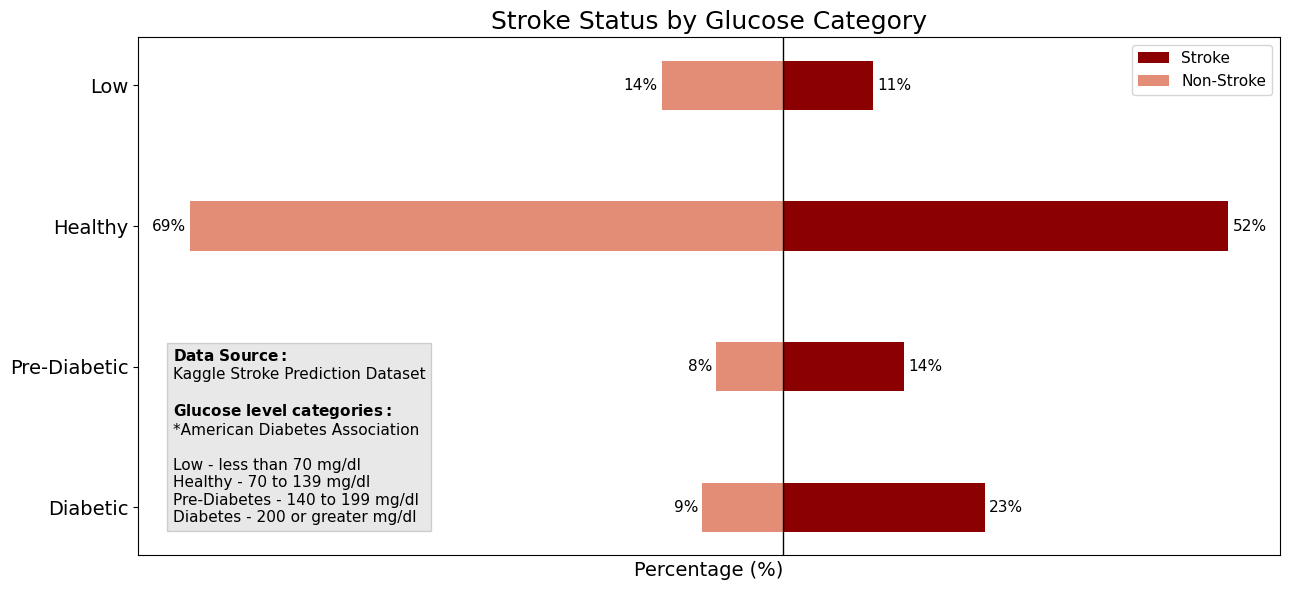

In [283]:


#  Labels and values
labels = ["Diabetic", "Pre-Diabetic", "Healthy", "Low"]

stroke_means     = np.array([dm_stroke_mean, p_dm_stroke_mean, h_gav_stroke_mean, l_gav_stroke_mean])
non_stroke_means = np.array([dm_no_stroke_mean, p_dm_no_stroke_mean, h_gav_no_stroke_mean, l_gav_no_stroke_mean])

y_pos = np.arange(len(labels))
bar_height = 0.35

# Step 6: Plot
fig, ax = plt.subplots(figsize=(13,6))

# Stroke bars (positive side)
bars_stroke = ax.barh(y_pos, stroke_means,
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Non-Stroke bars (negative side)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means,
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Step 7: Add labels outside bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Step 8: Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status by Glucose Category", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()
plt.text(
    0.03, 0.4,  # Posición relativa en el gráfico
    (
        r'$\mathbf{Data\ Source:}$'
        '\nKaggle Stroke Prediction Dataset\n'
        '\n'
        r'$\mathbf{Glucose\ level\ categories:}$'
        '\n*American Diabetes Association\n'
        '\nLow - less than 70 mg/dl\n'
        'Healthy - 70 to 139 mg/dl\n'
        'Pre-Diabetes - 140 to 199 mg/dl\n'
        'Diabetes - 200 or greater mg/dl'
    ),
    transform=plt.gca().transAxes,  # relativo al eje
    fontsize=11,
    color='black',
    ha='left',  # alineación horizontal
    va='top',   # alineación vertical
    bbox=dict(
        facecolor='lightgrey',   # fondo gris claro
        alpha=0.5,
        edgecolor='darkgrey',    # borde gris oscuro
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_gluc_category.png', format="png", dpi=300)
plt.show()


# Data Exploration Demographic Variables: gender, age, ever_married, work_type, residence_type vs. stroke

In [284]:
# df copy to graph demograpic variables processed in patients with and without stroke: gender, age, ever_married, work_type, residence_type vs. stroke

dem_var_df = stroke_adults[['gender', 'age','age_category', 'ever_married', 'work_type', 'residence_type', 'stroke']].copy()
dem_var_df .head()

,gender,age,age_category,ever_married,work_type,residence_type,stroke
0,Male,67.0,Senior,Yes,Private,Urban,1
1,Female,61.0,Adult,Yes,Self-employed,Rural,1
2,Male,80.0,Senior,Yes,Private,Rural,1
3,Female,49.0,Adult,Yes,Private,Urban,1
4,Female,79.0,Senior,Yes,Self-employed,Rural,1


### Gender

In [285]:
## Gender vrs Stroke Status

# Step 1: Counts
stroke_yes_total = (dem_var_df ['stroke'] == 1).sum()
stroke_no_total = (dem_var_df ['stroke'] == 0).sum()

# Within stroke=1
fem_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['gender'] == 'Female')).sum()
mal_stroke  = ((dem_var_df['stroke'] == 1) & (dem_var_df['gender'] == 'Male')).sum()

# Within stroke=0
fem_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['gender'] == 'Female')).sum()
mal_no_stroke  = ((dem_var_df['stroke'] == 0) & (dem_var_df['gender'] == 'Male')).sum()


# Calculate the mean: 
# Within stroke=1
fem_stroke_mean = (fem_stroke / stroke_yes_total)*100
mal_stroke_mean  = (mal_stroke / stroke_yes_total)*100

# Within stroke=0
fem_no_stroke_mean = (fem_no_stroke / stroke_no_total)*100
mal_no_stroke_mean  = (mal_no_stroke / stroke_no_total)*100

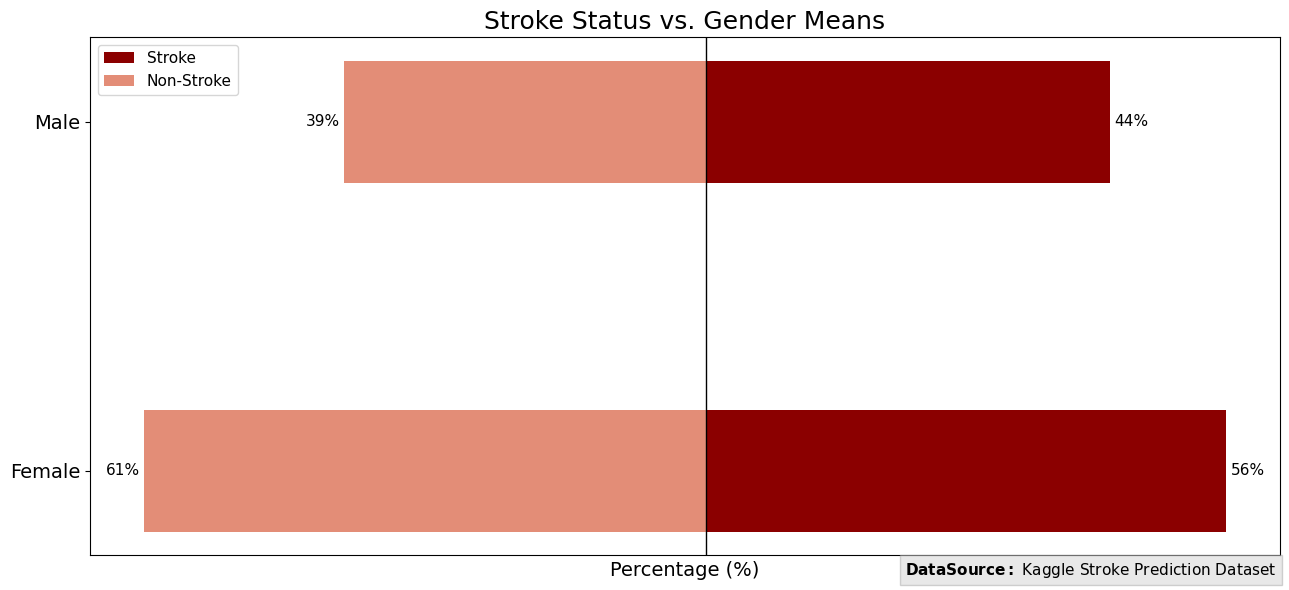

In [286]:
# Labels
labels = ["Female", "Male"]

# Values (percentages)
stroke_means = np.array([fem_stroke_mean, mal_stroke_mean])           # Stroke group
non_stroke_means = np.array([fem_no_stroke_mean, mal_no_stroke_mean]) # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 6))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, negative values for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels outside bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status vs. Gender Means", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="upper left", fontsize=11)

plt.tight_layout()
plt.text(
    0.685, -0.01,  # Text positioning from axes
     '$\mathbf{Data Source:}$ Kaggle Stroke Prediction Dataset', # Text - Data Source
    transform=plt.gca().transAxes,  # place relative to entire figure
    fontsize=11,
    color='black',
    ha='left',  # Horizontal text alignment inside box
    va='top',   # Vertical text alignment inside box
    bbox=dict(
        facecolor='lightgrey',   # Light red background,
        alpha=0.5,
        edgecolor='darkgrey',    # Border color
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_gender.png', format="png", dpi=300)
plt.show()


## Age

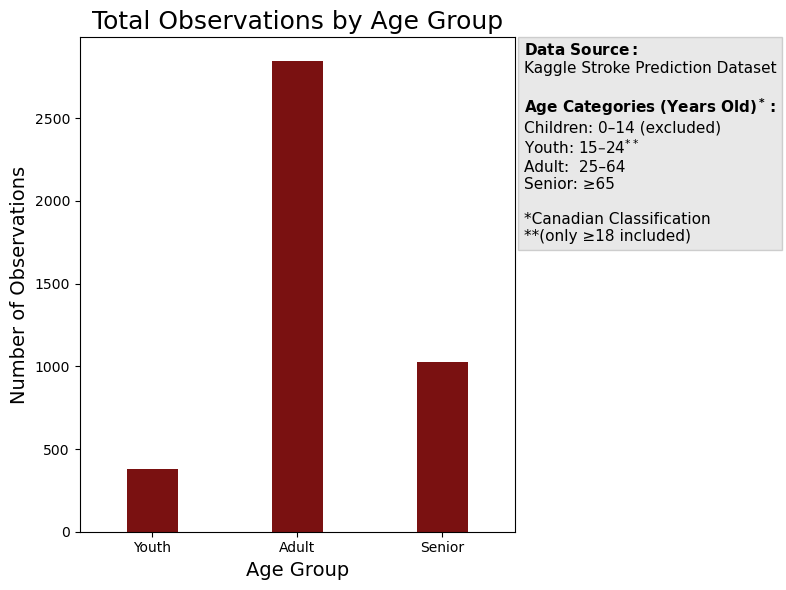

In [287]:
# Order of categories (excluding Children from the plot)
age_order = ['Youth', 'Adult', 'Senior']

# Bar Plot for Count of total observations by Age (categories)
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(
    data=dem_var_df,
    x='age_category',
    order=age_order,
    color='darkred',
    width=0.35,
    ax=ax   # draw on the defined axis
)

# Titles and labels
ax.set_title('Total Observations by Age Group', fontsize=18)
ax.set_xlabel('Age Group', fontsize=14)
ax.set_ylabel('Number of Observations', fontsize=14)

# Text box with data source and age classification
ax.text(
    1.02, 0.99,  # Position relative to axes
    (
        '$\mathbf{Data\ Source:}$\n'
        'Kaggle Stroke Prediction Dataset\n\n'
        '$\mathbf{Age\ Categories\ (Years\ Old)^*:}$\n'
        
        'Children: 0–14 (excluded)\n'
        'Youth: ${15–24}^{**}$\n'
        'Adult:  25–64 \n'
        'Senior: ≥65'
        '\n\n*Canadian Classification\n'
        '**(only ≥18 included)'
    ),
    transform=ax.transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.tight_layout()

plt.savefig('../images/stroke_comparative_visualizations/total_by_age_category.png', format="png", dpi=300)

plt.show()


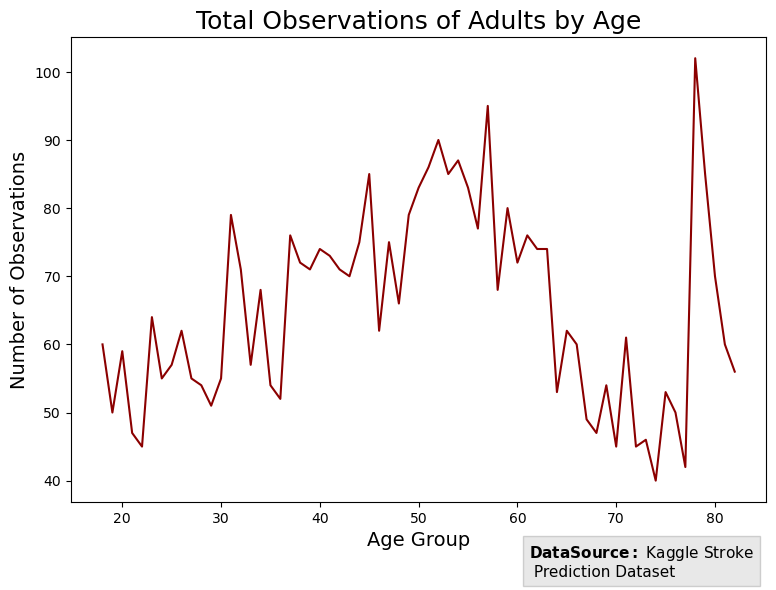

In [288]:
# Count Total Observations by age
age_counts = dem_var_df['age'].value_counts().sort_index()

# Bar Plot for Count of total observations  by age
age_counts.plot(kind='line', figsize=(8,6), color='darkred')
plt.title('Total Observations of Adults by Age', fontsize=18)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Observations', fontsize=14)

# Text box with data source 
plt.text(
    0.658, -0.09,  # Position relative to axes
    (
        '$\mathbf{Data Source:}$ Kaggle Stroke \n Prediction Dataset'),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.tight_layout()

plt.savefig('../images/stroke_comparative_visualizations/total_by_age.png', format="png", dpi=300)
plt.show()

# Comparative graph: age vrs. stroke and non stroke

In [289]:
## Age vrs Stroke Status
# age_category: ['Children', 'Youth', 'Adult', 'Senior']


# Step 1: Counts
stroke_yes_total = (dem_var_df ['stroke'] == 1).sum()
stroke_no_total = (dem_var_df ['stroke'] == 0).sum()

# Within stroke=1
sen_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['age_category'] == 'Senior')).sum()
adu_stroke  = ((dem_var_df['stroke'] == 1) & (dem_var_df['age_category'] == 'Adult')).sum()
yth_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['age_category'] == 'Youth')).sum()
chld_stroke  = ((dem_var_df['stroke'] == 1) & (dem_var_df['age_category'] == 'Children')).sum()

# Within stroke=0
sen_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['age_category'] == 'Senior')).sum()
adu_no_stroke  = ((dem_var_df['stroke'] == 0) & (dem_var_df['age_category'] == 'Adult')).sum()
yth_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['age_category'] == 'Youth')).sum()
chld_no_stroke  = ((dem_var_df['stroke'] == 0) & (dem_var_df['age_category'] == 'Children')).sum()

# Calculate the mean: 
# Within stroke=1
sen_stroke_mean = (sen_stroke / stroke_yes_total)*100
adu_stroke_mean  = (adu_stroke / stroke_yes_total)*100
yth_stroke_mean = (yth_stroke / stroke_yes_total)*100
chld_stroke_mean  = (chld_stroke / stroke_yes_total)*100

# Within stroke=0
sen_no_stroke_mean = (sen_no_stroke / stroke_no_total)*100
adu_no_stroke_mean  = (adu_no_stroke / stroke_no_total)*100
yth_no_stroke_mean = (yth_no_stroke / stroke_no_total)*100
chld_no_stroke_mean  = (chld_no_stroke / stroke_no_total)*100

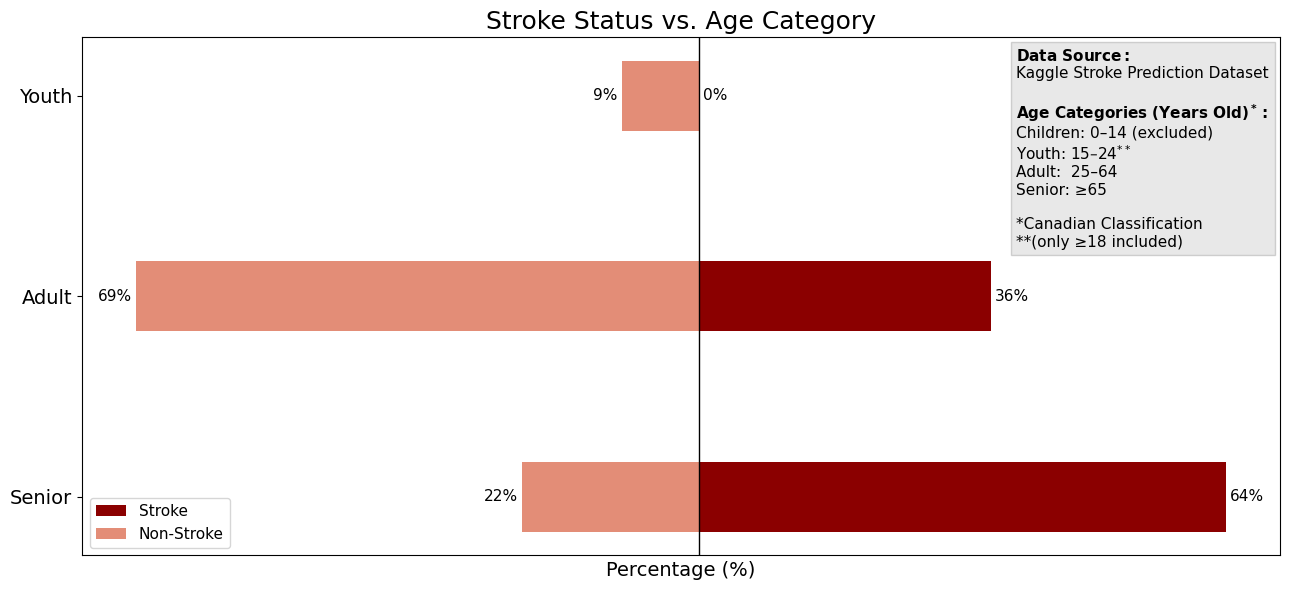

In [290]:
# Labels
labels = ["Senior", "Adult", "Youth"]

# Values (percentages)
stroke_means = np.array([
    sen_stroke_mean, 
    adu_stroke_mean, 
    yth_stroke_mean, 
])  # Stroke group

non_stroke_means = np.array([
    sen_no_stroke_mean, 
    adu_no_stroke_mean, 
    yth_no_stroke_mean, 
])  # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 6))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, negative values for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels outside bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)" , fontsize = 14)
ax.set_title("Stroke Status vs. Age Category", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="lower left", fontsize=11)

plt.tight_layout()

# Text box with data source and age classification
plt.text(
    0.78, 0.98,  # Position relative to axes
    (
        '$\mathbf{Data\ Source:}$\n'
        'Kaggle Stroke Prediction Dataset\n\n'
        '$\mathbf{Age\ Categories\ (Years\ Old)^*:}$\n'
        
        'Children: 0–14 (excluded)\n'
        'Youth: ${15–24}^{**}$\n'
        'Adult:  25–64 \n'
        'Senior: ≥65'
        '\n\n*Canadian Classification\n'
        '**(only ≥18 included)'
    ),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_age_category.png', format="png", dpi=300)
plt.show()


# Ever married

In [291]:
## Marital Status Vs. Stroke Status

# change categorical value gender to numerical value.

# Step 1: Counts
stroke_yes_total = (dem_var_df ['stroke'] == 1).sum()
stroke_no_total = (dem_var_df ['stroke'] == 0).sum()

# Within stroke=1
e_mar_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['ever_married'] == 'Yes')).sum()
n_mar_stroke  = ((dem_var_df['stroke'] == 1) & (dem_var_df['ever_married'] == 'No')).sum()

# Within stroke=0
e_mar_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['ever_married'] == 'Yes')).sum()
n_mar_no_stroke  = ((dem_var_df['stroke'] == 0) & (dem_var_df['ever_married'] == 'No')).sum()


# Calculate the mean: 
# Within stroke=1
e_mar_stroke_mean = (e_mar_stroke / stroke_yes_total)*100
n_mar_stroke_mean  = (n_mar_stroke / stroke_yes_total)*100

# Within stroke=0
e_mar_no_stroke_mean = (e_mar_no_stroke / stroke_no_total)*100
n_mar_no_stroke_mean  = (n_mar_no_stroke / stroke_no_total)*100

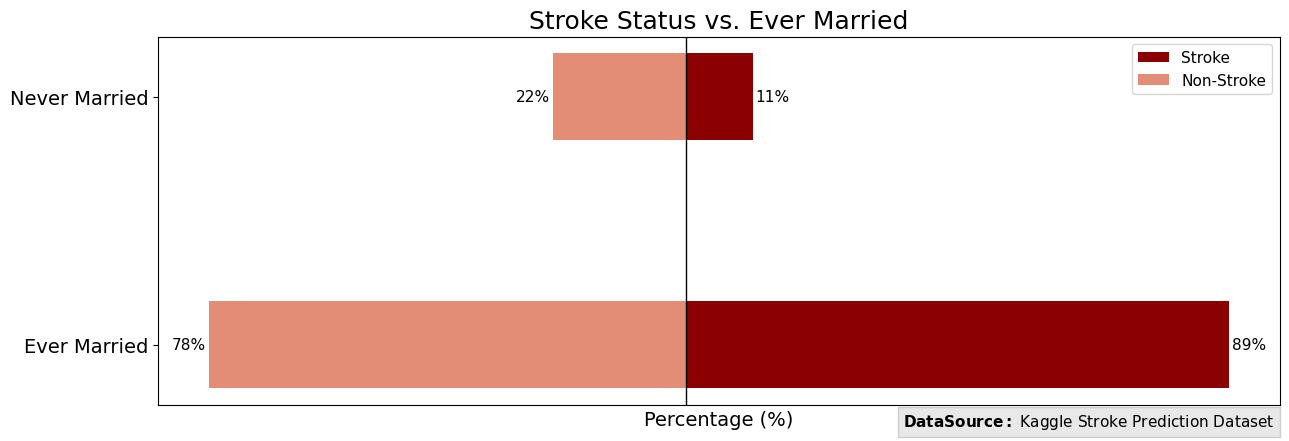

In [292]:
# Labels
labels = ["Ever Married", "Never Married"]

# Values (percentages)
stroke_means = np.array([e_mar_stroke_mean, n_mar_stroke_mean])           # Stroke group
non_stroke_means = np.array([e_mar_no_stroke_mean, n_mar_no_stroke_mean]) # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 4.5))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, negative values for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels to bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status vs. Ever Married", fontsize =18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()

# Text box with data source 
plt.text(
    0.664, -0.02,  # Position relative to axes
    ('$\mathbf{Data Source:}$ Kaggle Stroke Prediction Dataset'),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_maried_status.png', format="png", dpi=300)
plt.show()


## Work Type

In [293]:
## Work Type vrs Stroke Status: ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']

# Step 1: Counts
stroke_yes_total = (dem_var_df['stroke'] == 1).sum()
stroke_no_total  = (dem_var_df['stroke'] == 0).sum()

# Within stroke=1
pri_w_stroke   = ((dem_var_df['stroke'] == 1) & (dem_var_df['work_type'] == 'Private')).sum()
slf_emp_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['work_type'] == 'Self-employed')).sum()
gov_job_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['work_type'] == 'Govt_job')).sum()
chil_stroke    = ((dem_var_df['stroke'] == 1) & (dem_var_df['work_type'] == 'children')).sum()
nev_w_stroke   = ((dem_var_df['stroke'] == 1) & (dem_var_df['work_type'] == 'Never_worked')).sum()

# Within stroke=0
pri_w_no_stroke   = ((dem_var_df['stroke'] == 0) & (dem_var_df['work_type'] == 'Private')).sum()
slf_emp_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['work_type'] == 'Self-employed')).sum()
gov_job_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['work_type'] == 'Govt_job')).sum()
chil_no_stroke    = ((dem_var_df['stroke'] == 0) & (dem_var_df['work_type'] == 'children')).sum()
nev_w_no_stroke   = ((dem_var_df['stroke'] == 0) & (dem_var_df['work_type'] == 'Never_worked')).sum()

# Calculate the mean: 
# Within stroke=1
pri_w_stroke_mean   = (pri_w_stroke / stroke_yes_total) * 100
slf_emp_stroke_mean = (slf_emp_stroke / stroke_yes_total) * 100
gov_job_stroke_mean = (gov_job_stroke / stroke_yes_total) * 100
chil_stroke_mean    = (chil_stroke / stroke_yes_total) * 100
nev_w_stroke_mean   = (nev_w_stroke / stroke_yes_total) * 100

# Within stroke=0
pri_w_no_stroke_mean   = (pri_w_no_stroke / stroke_no_total) * 100
slf_emp_no_stroke_mean = (slf_emp_no_stroke / stroke_no_total) * 100
gov_job_no_stroke_mean = (gov_job_no_stroke / stroke_no_total) * 100
chil_no_stroke_mean    = (chil_no_stroke / stroke_no_total) * 100
nev_w_no_stroke_mean   = (nev_w_no_stroke / stroke_no_total) * 100


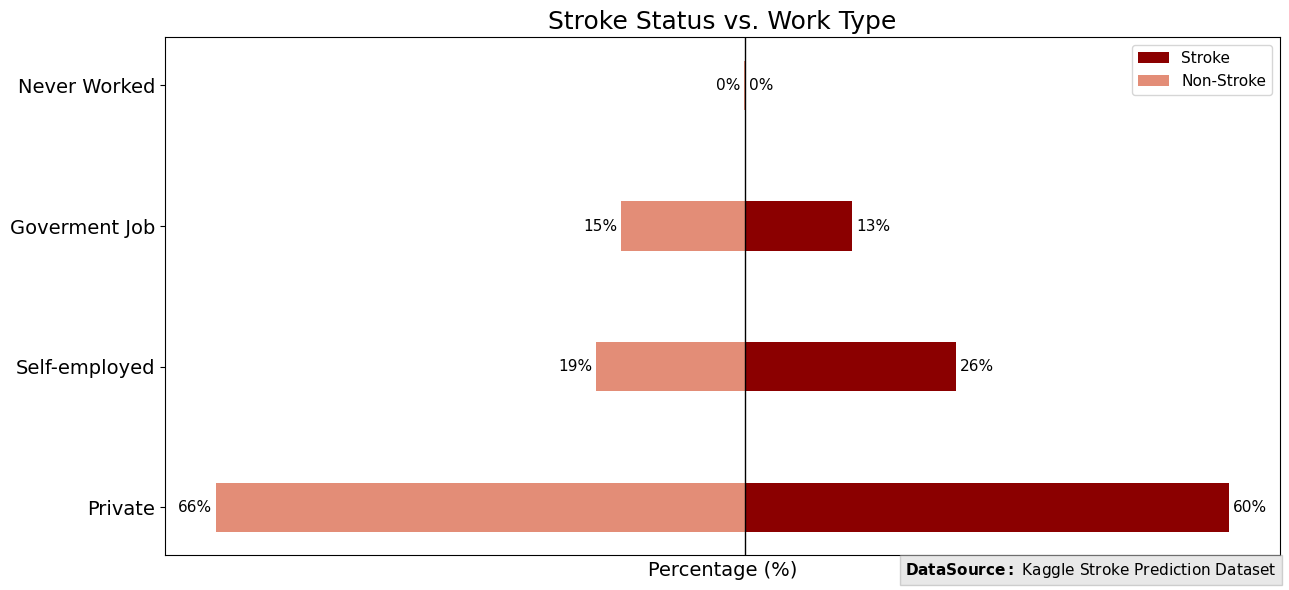

In [294]:

# Labels
labels = ["Private", "Self-employed", "Goverment Job", "Never Worked"]

# Values (percentages)
stroke_means = np.array([
    pri_w_stroke_mean, 
    slf_emp_stroke_mean, 
    gov_job_stroke_mean, 
    nev_w_stroke_mean
])  # Stroke group

non_stroke_means = np.array([
    pri_w_no_stroke_mean, 
    slf_emp_no_stroke_mean, 
    gov_job_no_stroke_mean, 
    nev_w_no_stroke_mean
])  # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 6))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, negative values for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels to bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status vs. Work Type", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="upper right", fontsize=11)

plt.tight_layout()

# Text box with data source 
plt.text(
    0.664, -0.01,  # Position relative to axes
    ('$\mathbf{Data Source:}$ Kaggle Stroke Prediction Dataset'),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_work_type.png', format="png", dpi=300)
plt.show()


## Residence Type

In [295]:
## Residence Type vrs Stroke Status:


# Step 1: Counts
stroke_yes_total = (dem_var_df ['stroke'] == 1).sum()
stroke_no_total = (dem_var_df ['stroke'] == 0).sum()

# Within stroke=1
urb_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['residence_type'] == 'Urban')).sum()
rur_stroke  = ((dem_var_df['stroke'] == 1) & (dem_var_df['residence_type'] == 'Rural')).sum()

# Within stroke=0
urb_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['residence_type'] == 'Urban')).sum()
rur_no_stroke  = ((dem_var_df['stroke'] == 0) & (dem_var_df['residence_type'] == 'Rural')).sum()


# Calculate the mean: 
# Within stroke=1
urb_stroke_mean = (urb_stroke / stroke_yes_total)*100
rur_stroke_mean  = (rur_stroke / stroke_yes_total)*100

# Within stroke=0
urb_no_stroke_mean = (rur_no_stroke / stroke_no_total)*100
urb_no_stroke_mean  = (rur_no_stroke / stroke_no_total)*100

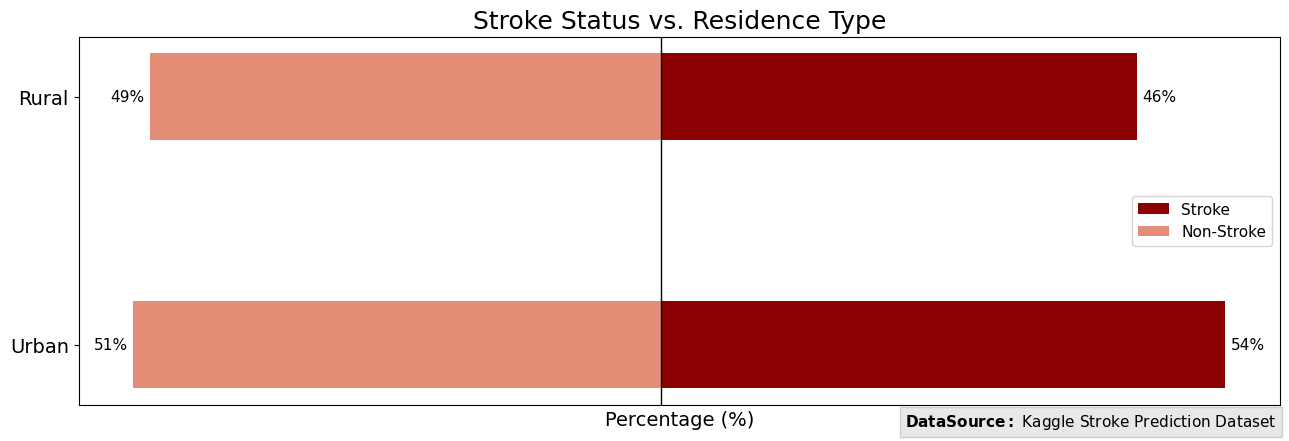

In [296]:
# Step 1: Counts
stroke_yes_total = (dem_var_df['stroke'] == 1).sum()
stroke_no_total  = (dem_var_df['stroke'] == 0).sum()

# Within stroke=1
urb_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['residence_type'] == 'Urban')).sum()
rur_stroke = ((dem_var_df['stroke'] == 1) & (dem_var_df['residence_type'] == 'Rural')).sum()

# Within stroke=0
urb_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['residence_type'] == 'Urban')).sum()
rur_no_stroke = ((dem_var_df['stroke'] == 0) & (dem_var_df['residence_type'] == 'Rural')).sum()

# Calculate the mean: 
# Within stroke=1
urb_stroke_mean = (urb_stroke / stroke_yes_total) * 100
rur_stroke_mean = (rur_stroke / stroke_yes_total) * 100

# Within stroke=0
urb_no_stroke_mean = (urb_no_stroke / stroke_no_total) * 100
rur_no_stroke_mean = (rur_no_stroke / stroke_no_total) * 100

# Labels
labels = ["Urban", "Rural"]

# Values (percentages)
stroke_means = np.array([urb_stroke_mean, rur_stroke_mean])           # Stroke group
non_stroke_means = np.array([urb_no_stroke_mean, rur_no_stroke_mean]) # Non-Stroke group

y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(13, 4.5))

bar_height = 0.35  # thickness of bars

# Plot Stroke (right side, positive values)
bars_stroke = ax.barh(y_pos, stroke_means, 
                      height=bar_height, color="darkred", label="Stroke", align="center")

# Plot Non-Stroke (left side, negative values for plotting)
bars_non_stroke = ax.barh(y_pos, -non_stroke_means, 
                          height=bar_height, color="#e38d77", label="Non-Stroke", align="center")

# Add labels to bars
for bar in bars_stroke:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="left", va="center", color="black", fontsize=11)

for bar in bars_non_stroke:
    width = bar.get_width()
    ax.text(width - 0.5, bar.get_y() + bar.get_height()/2,
            f"{abs(width):.0f}%", ha="right", va="center", color="black", fontsize=11)

# Formatting
ax.set_xticks([])
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xlabel("Percentage (%)", fontsize=14)
ax.set_title("Stroke Status vs. Residence Type", fontsize=18)
ax.axvline(0, color="black", linewidth=1)  # center line
ax.legend(loc="center right", fontsize=11)

plt.tight_layout()

# Text box with data source 
plt.text(
    0.688, -0.02,  # Position relative to axes
    ('$\mathbf{Data Source:}$ Kaggle Stroke Prediction Dataset'),
    transform=plt.gca().transAxes,
    fontsize=11,
    color='black',
    ha='left',
    va='top',
    bbox=dict(
        facecolor='lightgrey',
        alpha=0.5,
        edgecolor='darkgrey'
    )
)
plt.savefig('../images/stroke_comparative_visualizations/comparative_by_resid_type.png', format="png", dpi=300)
plt.show()
